In [1]:
import os, random, re, json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


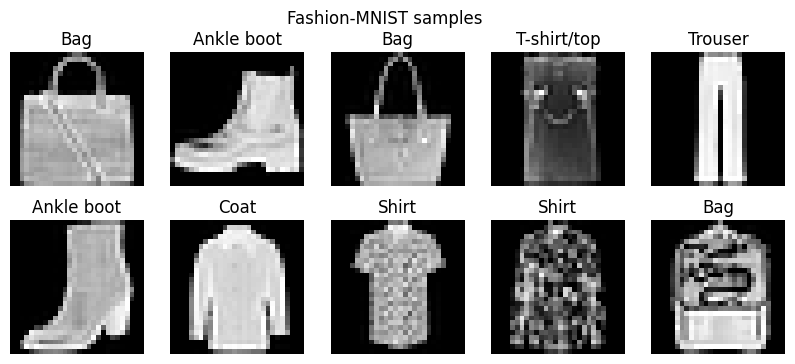

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=SEED,
    stratify=y_train
)

# normalize to [0,1]
x_train_n = (x_train.astype("float32") / 255.0)
x_val_n   = (x_val.astype("float32") / 255.0)
x_test_n  = (x_test.astype("float32") / 255.0)

# add channel dim for CNN
x_train_c = np.expand_dims(x_train_n, -1)  # (N,28,28,1)
x_val_c   = np.expand_dims(x_val_n, -1)
x_test_c  = np.expand_dims(x_test_n, -1)

# quick visualization
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.suptitle("Fashion-MNIST samples")
plt.show()

In [5]:
def plot_history(history, title_prefix="Model"):
    hist = history.history

    plt.figure(figsize=(7,4))
    plt.plot(hist["loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title(f"{title_prefix}: Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True); plt.legend()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(hist["accuracy"], label="train")
    plt.plot(hist["val_accuracy"], label="val")
    plt.title(f"{title_prefix}: Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True); plt.legend()
    plt.show()

def evaluate_and_report(model, x, y, title="Model", show_cm=True):
    test_loss, test_acc = model.evaluate(x, y, verbose=0)
    print(f"\n[{title}] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    y_prob = model.predict(x, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print("\nClassification report:")
    print(classification_report(y, y_pred, target_names=class_names, digits=4))

    if show_cm:
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        plt.figure(figsize=(9,8))
        disp.plot(xticks_rotation=45, values_format="d")
        plt.title(f"Confusion Matrix: {title}")
        plt.show()

    return test_acc, test_loss, y_pred

def show_random_predictions(model, x, y, title="Predictions", n=10):
    idx = np.random.choice(len(x), size=n, replace=False)
    y_prob = model.predict(x[idx], verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    plt.figure(figsize=(12,5))
    for i, k in enumerate(idx):
        plt.subplot(2,5,i+1)
        # handle both (28,28) and (28,28,1)
        img = x[k] if x.ndim == 3 else x[k,:,:,0]
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"T:{class_names[y[k]]}\nP:{class_names[y_pred[i]]}")
    plt.suptitle(title)
    plt.show()

    mistakes = int(np.sum(y[idx] != y_pred))
    print(f"Mistakes in these {n} images: {mistakes}/{n}")

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6558 - loss: 0.9791 - val_accuracy: 0.8537 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8339 - loss: 0.4755 - val_accuracy: 0.8705 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8508 - loss: 0.4146 - val_accuracy: 0.8800 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8589 - loss: 0.3851 - val_accuracy: 0.8858 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8689 - loss: 0.3610 - val_accuracy: 0.8842 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8718 - loss: 0.3483 - val_accuracy: 0.8837 - val_loss: 0.3198 - learning_rate: 0.0010
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8757 - loss: 0.3403 

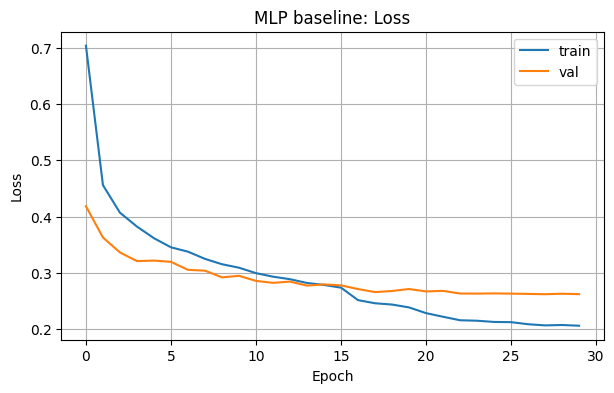

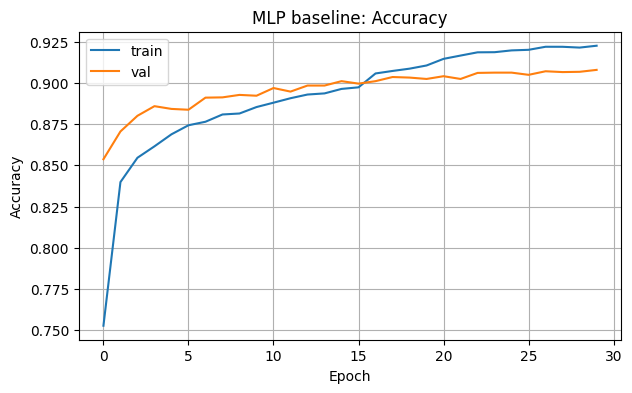


[MLP baseline] Test loss: 0.3061 | Test accuracy: 0.8963

Classification report:
              precision    recall  f1-score   support

 T-shirt/top     0.8478    0.8580    0.8529      1000
     Trouser     0.9929    0.9760    0.9844      1000
    Pullover     0.8114    0.8090    0.8102      1000
       Dress     0.8956    0.9090    0.9022      1000
        Coat     0.8160    0.8250    0.8205      1000
      Sandal     0.9778    0.9690    0.9734      1000
       Shirt     0.7290    0.7130    0.7209      1000
     Sneaker     0.9444    0.9690    0.9566      1000
         Bag     0.9760    0.9780    0.9770      1000
  Ankle boot     0.9716    0.9570    0.9642      1000

    accuracy                         0.8963     10000
   macro avg     0.8963    0.8963    0.8962     10000
weighted avg     0.8963    0.8963    0.8962     10000



<Figure size 900x800 with 0 Axes>

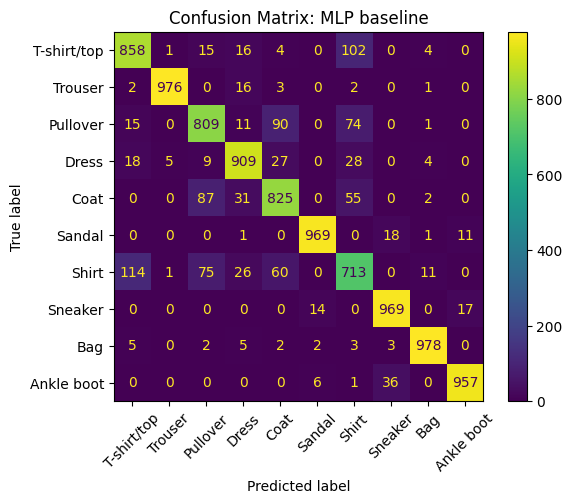

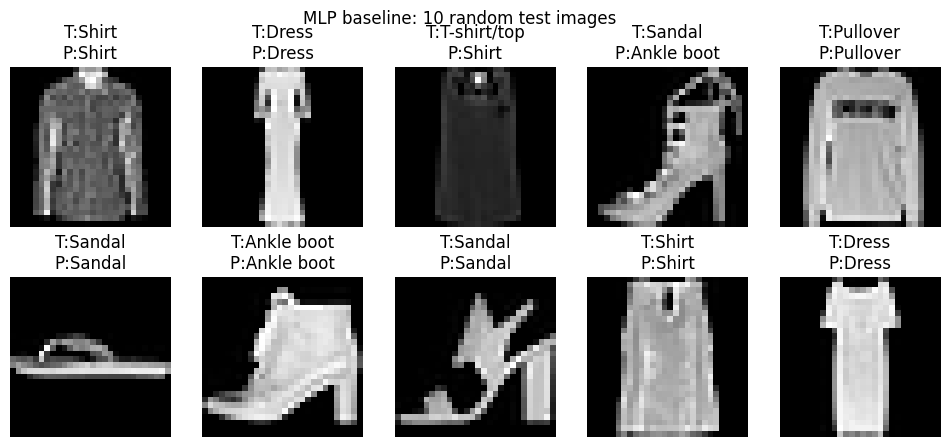

Mistakes in these 10 images: 2/10


In [6]:
mlp = keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
], name="MLP_baseline")

mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_mlp = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

hist_mlp = mlp.fit(
    x_train_n, y_train,
    validation_data=(x_val_n, y_val),
    epochs=30,
    batch_size=256,
    callbacks=callbacks_mlp,
    verbose=1
)

plot_history(hist_mlp, "MLP baseline")
mlp_acc, mlp_loss, _ = evaluate_and_report(mlp, x_test_n, y_test, "MLP baseline")
show_random_predictions(mlp, x_test_n, y_test, "MLP baseline: 10 random test images", n=10)

Epoch 1/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.5503 - loss: 1.2264 - val_accuracy: 0.2215 - val_loss: 3.1409 - learning_rate: 0.0010
Epoch 2/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7633 - loss: 0.6470 - val_accuracy: 0.6308 - val_loss: 1.1173 - learning_rate: 0.0010
Epoch 3/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7911 - loss: 0.5675 - val_accuracy: 0.8295 - val_loss: 0.4577 - learning_rate: 0.0010
Epoch 4/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8121 - loss: 0.5139 - val_accuracy: 0.7402 - val_loss: 0.7506 - learning_rate: 0.0010
Epoch 5/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8232 - loss: 0.4827 - val_accuracy: 0.8293 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 6/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8330 - loss: 0.4650 - val_accuracy: 0.8595 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 7/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8416 - loss: 

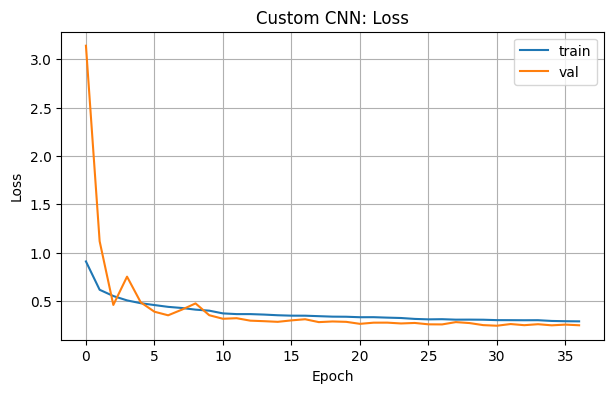

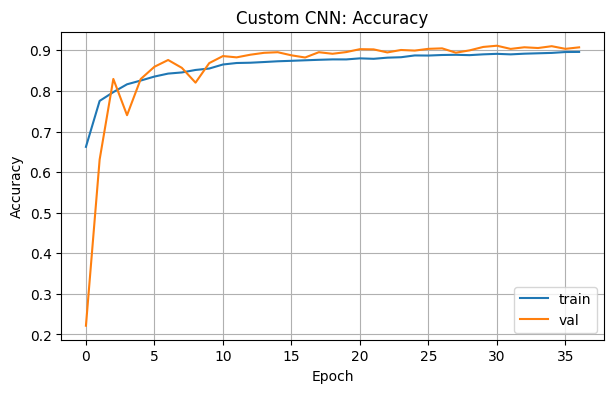


[Custom CNN] Test loss: 0.2780 | Test accuracy: 0.8987

Classification report:
              precision    recall  f1-score   support

 T-shirt/top     0.8499    0.8660    0.8579      1000
     Trouser     0.9898    0.9740    0.9819      1000
    Pullover     0.8560    0.8920    0.8737      1000
       Dress     0.9160    0.8720    0.8934      1000
        Coat     0.8345    0.8570    0.8456      1000
      Sandal     0.9763    0.9490    0.9625      1000
       Shirt     0.7193    0.6920    0.7054      1000
     Sneaker     0.9229    0.9460    0.9343      1000
         Bag     0.9667    0.9870    0.9767      1000
  Ankle boot     0.9558    0.9520    0.9539      1000

    accuracy                         0.8987     10000
   macro avg     0.8987    0.8987    0.8985     10000
weighted avg     0.8987    0.8987    0.8985     10000



<Figure size 900x800 with 0 Axes>

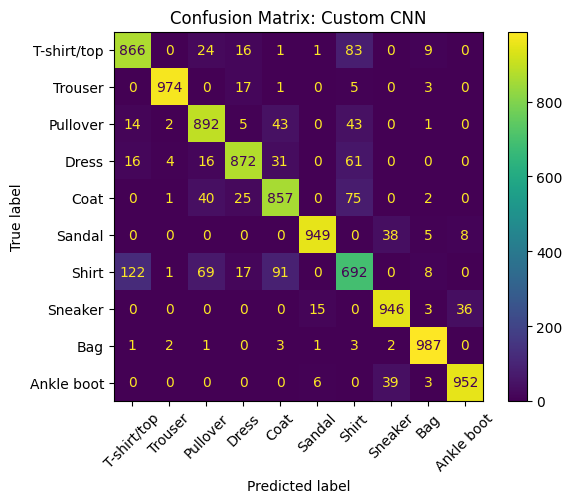

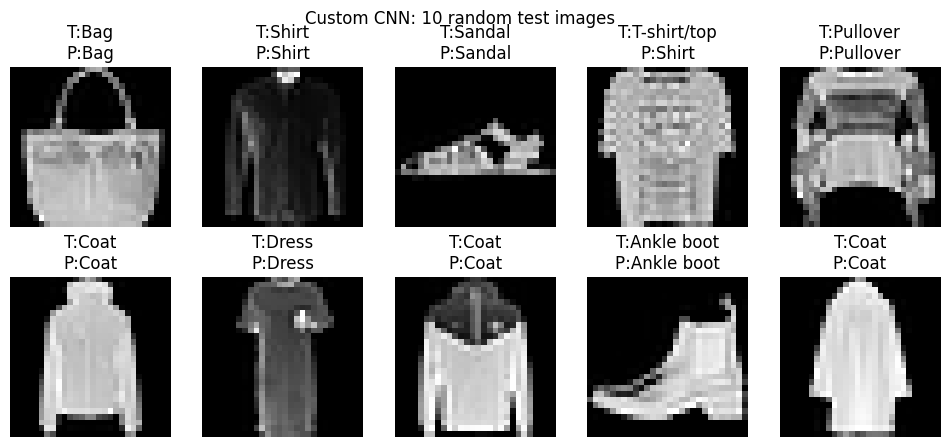

Mistakes in these 10 images: 1/10


In [7]:
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
], name="augmentation")

cnn = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    augmentation,

    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(10, activation="softmax")
], name="Custom_CNN")

cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_cnn = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

hist_cnn = cnn.fit(
    x_train_c, y_train,
    validation_data=(x_val_c, y_val),
    epochs=40,
    batch_size=128,
    callbacks=callbacks_cnn,
    verbose=1
)

plot_history(hist_cnn, "Custom CNN")
cnn_acc, cnn_loss, _ = evaluate_and_report(cnn, x_test_c, y_test, "Custom CNN")
show_random_predictions(cnn, x_test_c, y_test, "Custom CNN: 10 random test images", n=10)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 96
BATCH = 64

x_train_raw = x_train.astype("float32")
x_val_raw   = x_val.astype("float32")
x_test_raw  = x_test.astype("float32")

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

def vgg_preprocess(x, y):
    # (28,28) - (H,W,3) + preprocess
    x = tf.expand_dims(x, axis=-1)
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    x = tf.image.grayscale_to_rgb(x)
    x = preprocess_input(x)
    return x, y

ds_train = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train))
ds_train = ds_train.shuffle(20000, seed=SEED) \
                   .map(vgg_preprocess, num_parallel_calls=AUTOTUNE) \
                   .batch(BATCH) \
                   .prefetch(AUTOTUNE)

ds_val = tf.data.Dataset.from_tensor_slices((x_val_raw, y_val))
ds_val = ds_val.map(vgg_preprocess, num_parallel_calls=AUTOTUNE) \
               .batch(BATCH) \
               .prefetch(AUTOTUNE)

ds_test = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test))
ds_test = ds_test.map(vgg_preprocess, num_parallel_calls=AUTOTUNE) \
                 .batch(BATCH) \
                 .prefetch(AUTOTUNE)

# Build model
base = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)

vgg_model = keras.Model(inputs, outputs, name="VGG16_FashionMNIST")

vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_vgg = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_FashionMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_report_ds(model, ds, title="Model", show_cm=True):
    # 1) evaluate
    test_loss, test_acc = model.evaluate(ds, verbose=0)
    print(f"\n[{title}] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    # 2) predict batch-by-batch
    y_true_all = []
    y_pred_all = []

    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        y_pred = np.argmax(probs, axis=1)

        y_true_all.append(yb.numpy())
        y_pred_all.append(y_pred)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    print("\nClassification report:")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names, digits=4))

    if show_cm:
        cm = confusion_matrix(y_true_all, y_pred_all)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        plt.figure(figsize=(9, 8))
        disp.plot(xticks_rotation=45, values_format="d")
        plt.title(f"Confusion Matrix: {title}")
        plt.show()

    return test_acc, test_loss, y_pred_all


Epoch 1/6
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9918 - loss: 0.0249 - val_accuracy: 0.9432 - val_loss: 0.2328 - learning_rate: 2.5000e-06
Epoch 2/6
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9933 - loss: 0.0211 - val_accuracy: 0.9448 - val_loss: 0.2486 - learning_rate: 2.5000e-06
Epoch 3/6
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9940 - loss: 0.0191 - val_accuracy: 0.9453 - val_loss: 0.2502 - learning_rate: 2.5000e-06
Epoch 4/6
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9440 - val_loss: 0.2581 - learning_rate: 1.2500e-06
Epoch 5/6
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9442 - val_loss: 0.2511 - learning_rate: 1.2500e-06
Epoch 6/6
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9966 - loss: 0.0122 - val_accuracy: 0.9447 - val_loss: 0.2608 - learning_rate: 1.0000e-06


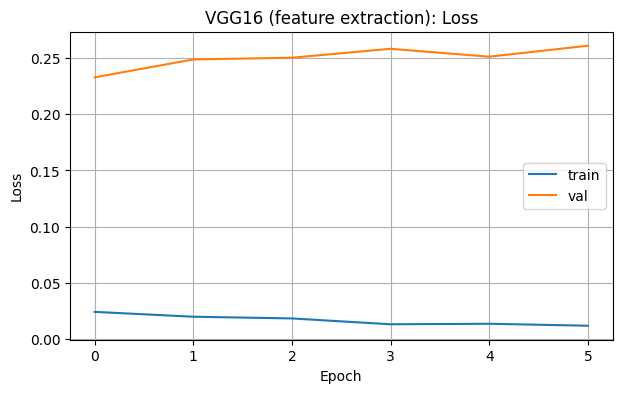

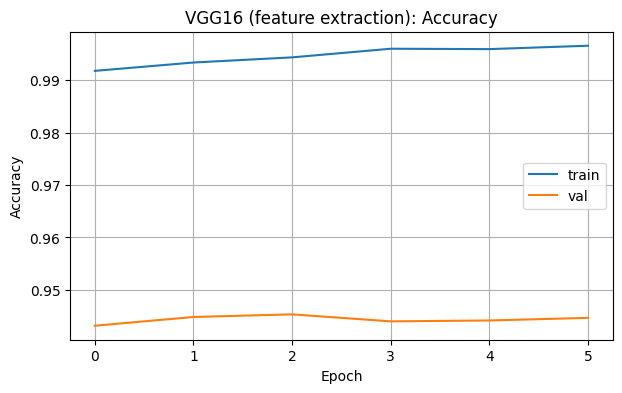


[VGG16 (feature extraction)] Test loss: 0.2844 | Test accuracy: 0.9398

Classification report:
              precision    recall  f1-score   support

 T-shirt/top     0.8852    0.9020    0.8935      1000
     Trouser     0.9980    0.9820    0.9899      1000
    Pullover     0.9315    0.8980    0.9145      1000
       Dress     0.9196    0.9380    0.9287      1000
        Coat     0.9075    0.9320    0.9196      1000
      Sandal     0.9910    0.9890    0.9900      1000
       Shirt     0.8228    0.8080    0.8153      1000
     Sneaker     0.9686    0.9870    0.9777      1000
         Bag     0.9880    0.9920    0.9900      1000
  Ankle boot     0.9858    0.9690    0.9773      1000

    accuracy                         0.9397     10000
   macro avg     0.9398    0.9397    0.9397     10000
weighted avg     0.9398    0.9397    0.9397     10000



<Figure size 900x800 with 0 Axes>

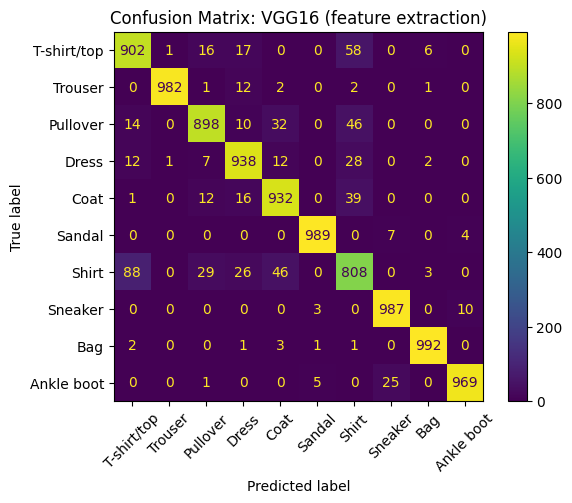

In [13]:
hist_vgg_1 = vgg_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=6,
    callbacks=callbacks_vgg,
    verbose=1
)

plot_history(hist_vgg_1, "VGG16 (feature extraction)")
vgg_acc_1, vgg_loss_1, _ = evaluate_and_report_ds(
    vgg_model, ds_test, "VGG16 (feature extraction)", show_cm=True
)

Epoch 1/4
844/844 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.9876 - loss: 0.0361 - val_accuracy: 0.9368 - val_loss: 0.2543 - learning_rate: 1.0000e-05
Epoch 2/4
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9876 - loss: 0.0368 - val_accuracy: 0.9367 - val_loss: 0.2465 - learning_rate: 1.0000e-05
Epoch 3/4
844/844 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9888 - loss: 0.0341 - val_accuracy: 0.9408 - val_loss: 0.2376 - learning_rate: 1.0000e-05
Epoch 4/4
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9897 - loss: 0.0280 - val_accuracy: 0.9403 - val_loss: 0.2688 - learning_rate: 1.0000e-05


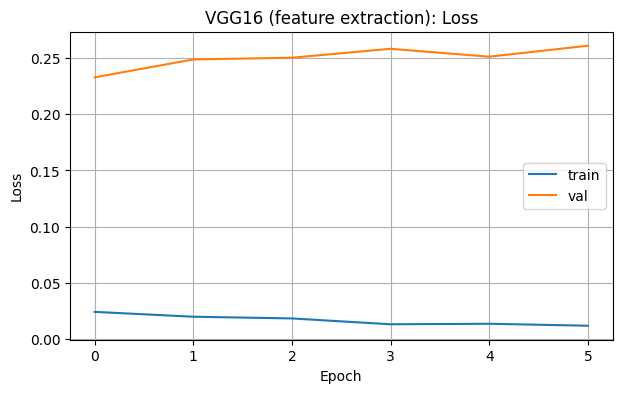

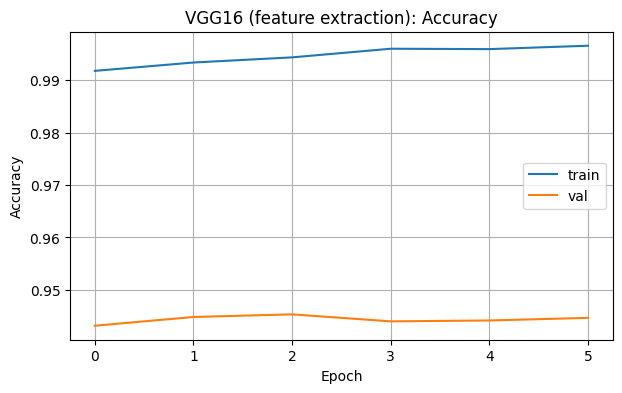


[VGG16 (feature extraction)] Test loss: 0.2629 | Test accuracy: 0.9355

Classification report:
              precision    recall  f1-score   support

 T-shirt/top     0.8983    0.8740    0.8860      1000
     Trouser     0.9920    0.9860    0.9890      1000
    Pullover     0.8887    0.9340    0.9108      1000
       Dress     0.9209    0.9310    0.9259      1000
        Coat     0.9350    0.8920    0.9130      1000
      Sandal     0.9880    0.9910    0.9895      1000
       Shirt     0.8012    0.8060    0.8036      1000
     Sneaker     0.9612    0.9900    0.9754      1000
         Bag     0.9822    0.9940    0.9881      1000
  Ankle boot     0.9907    0.9570    0.9736      1000

    accuracy                         0.9355     10000
   macro avg     0.9358    0.9355    0.9355     10000
weighted avg     0.9358    0.9355    0.9355     10000



<Figure size 900x800 with 0 Axes>

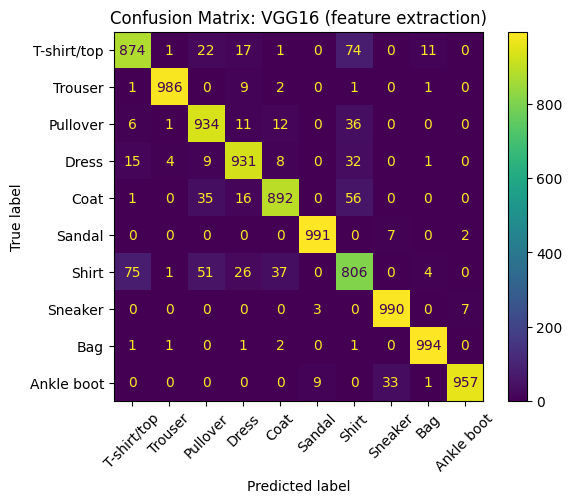

In [14]:
base.trainable = True

# Freeze early layers
N_UNFREEZE = 8
for layer in base.layers[:-N_UNFREEZE]:
    layer.trainable = False

vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # tiny LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_vgg_ft = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-7)
]

hist_vgg_2 = vgg_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=4,
    callbacks=callbacks_vgg_ft,
    verbose=1
)

plot_history(hist_vgg_1, "VGG16 (feature extraction)")
vgg_acc_1, vgg_loss_1, _ = evaluate_and_report_ds(
    vgg_model, ds_test, "VGG16 (feature extraction)", show_cm=True
)

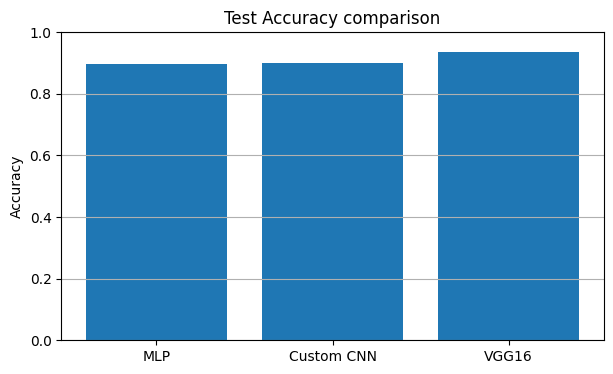

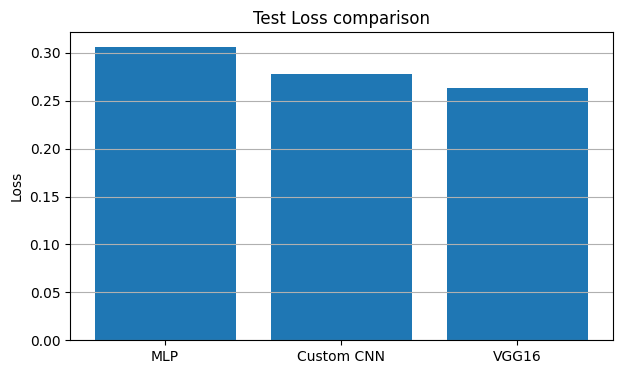

MLP        | acc=0.8963 | loss=0.3061
Custom CNN | acc=0.8987 | loss=0.2780
VGG16      | acc=0.9355 | loss=0.2629


In [15]:
final_vgg_acc  = vgg_acc_2  if "vgg_acc_2" in globals() else vgg_acc_1
final_vgg_loss = vgg_loss_2 if "vgg_loss_2" in globals() else vgg_loss_1

models = ["MLP", "Custom CNN", "VGG16"]
accs   = [mlp_acc, cnn_acc, final_vgg_acc]
losses = [mlp_loss, cnn_loss, final_vgg_loss]

plt.figure(figsize=(7,4))
plt.bar(models, accs)
plt.title("Test Accuracy comparison")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.grid(True, axis="y")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(models, losses)
plt.title("Test Loss comparison")
plt.ylabel("Loss")
plt.grid(True, axis="y")
plt.show()

for m,a,l in zip(models, accs, losses):
    print(f"{m:10s} | acc={a:.4f} | loss={l:.4f}")

In [16]:
os.makedirs("saved_models", exist_ok=True)

mlp.save("saved_models/mlp_baseline.keras")
cnn.save("saved_models/custom_cnn.keras")
vgg_model.save("saved_models/vgg16_fashionmnist.keras")

print("Saved models to ./saved_models")

Saved models to ./saved_models


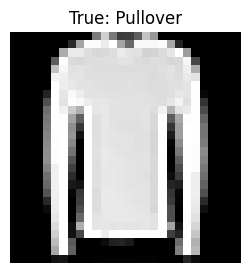

MLP     -> Pullover maxP= 0.9931640625
CNN     -> Pullover maxP= 0.99609375
VGG16   -> Pullover maxP= 0.9970703125


In [17]:
def preprocess_for_mlp_or_cnn(img_28x28):
    # img: uint8/float, shape (28,28)
    x = img_28x28.astype("float32") / 255.0
    return x

def preprocess_for_vgg(img_28x28):
    x = tf.convert_to_tensor(img_28x28, dtype=tf.float32)
    x = tf.expand_dims(x, axis=-1)
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    x = tf.image.grayscale_to_rgb(x)
    x = preprocess_input(x)
    return x

def predict_one(model_name, img_28x28):
    if model_name == "MLP":
        x = preprocess_for_mlp_or_cnn(img_28x28)
        x = np.expand_dims(x, 0)           # (1,28,28)
        probs = mlp.predict(x, verbose=0)[0]
    elif model_name == "Custom CNN":
        x = preprocess_for_mlp_or_cnn(img_28x28)
        x = np.expand_dims(x, (0,-1))      # (1,28,28,1)
        probs = cnn.predict(x, verbose=0)[0]
    elif model_name == "VGG16":
        x = preprocess_for_vgg(img_28x28)
        x = tf.expand_dims(x, 0)           # (1,H,W,3)
        probs = vgg_model.predict(x, verbose=0)[0]
    else:
        raise ValueError("Unknown model_name")

    pred = int(np.argmax(probs))
    return pred, probs

# demo prediction on random test image
k = np.random.randint(0, len(x_test))
img = x_test[k]
true = y_test[k]
pred_mlp, p_mlp = predict_one("MLP", img)
pred_cnn, p_cnn = predict_one("Custom CNN", img)
pred_vgg, p_vgg = predict_one("VGG16", img)

plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title(f"True: {class_names[true]}")
plt.show()

print("MLP     ->", class_names[pred_mlp],  "maxP=", float(np.max(p_mlp)))
print("CNN     ->", class_names[pred_cnn],  "maxP=", float(np.max(p_cnn)))
print("VGG16   ->", class_names[pred_vgg],  "maxP=", float(np.max(p_vgg)))

In [18]:
print("\nCONCLUSIONS (template)")
print("- MLP is a simple baseline; usually lower accuracy than CNN.")
print("- Custom CNN leverages spatial features and tends to outperform MLP.")
print("- VGG16 transfer learning can improve results, but may be slow on CPU due to resizing and heavy backbone.")
print("- Fine-tuning last layers can add a bit of accuracy but requires small LR and more compute.")
print("- For the web app task: you can load the saved models and run predict_one() logic after image upload.")


CONCLUSIONS (template)
- MLP is a simple baseline; usually lower accuracy than CNN.
- Custom CNN leverages spatial features and tends to outperform MLP.
- VGG16 transfer learning can improve results, but may be slow on CPU due to resizing and heavy backbone.
- Fine-tuning last layers can add a bit of accuracy but requires small LR and more compute.
- For the web app task: you can load the saved models and run predict_one() logic after image upload.


In [20]:
# CNN model save
cnn.save("models/cnn_fashionmnist.keras")

# VGG model save
vgg_model.save("models/vgg16_fashionmnist.keras")
print("Saved models to models/")


Saved models to models/


In [21]:
import os, json
os.makedirs("models", exist_ok=True)

with open("models/history_cnn.json", "w") as f:
    json.dump(hist_cnn.history, f)

with open("models/history_vgg_feat.json", "w") as f:
    json.dump(hist_vgg_1.history, f)

print("Saved histories to models/")

Saved histories to models/
